# 12. Data augmentation MCMC - adding and deleting events

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/12-data-augmentation-mcmc-2.ipynb)

__Date:__ Sept 12, 2024

## Learning Outcomes
- Examine move algorithm's edge cases
- Identify all possible other moves that can be made within an MCMC
- Identify computational challenge for these moves
- Use built-in `gemlib` samplers to handle these cases


## Theory

Censored event times are a common occurence in practice when modeling epidemics. The Bayesian approach of setting unobserved event times as model parameters gives us the ability to estimate those missing events through their relation to the observed events. However, the move algorithm does not cover _all_ possible types of missing observations. Even a more complex (or constrained) proposal function would not account for all possibilities.

The last exercise of the previous [Data Augmentation MCMC I](https://colab.research.google.com/drive/1xbvgxyc81JD5EGk8VzCgg882sU1fh5Sa#scrollTo=8vXmcac9vgiY) session used a symmetric uniform proposal distribution to shift event times to different time steps of the epidemic. Due to the stochastic nature of the MCMC algorithms, it is possible for the function to propose an event time _outside_ of the observation window. The diagrams below show some of the possible out of window moves that the sampler can propose.


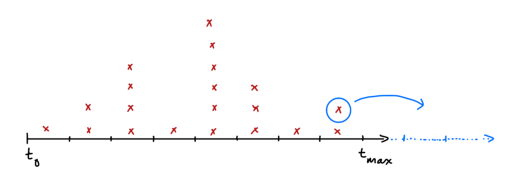

In [ ]:
# @title
# right hand delete event
img = mpimg.imread('/content/rh_del_event.png')
plt.imshow(img)
plt.axis('off')
plt.show()

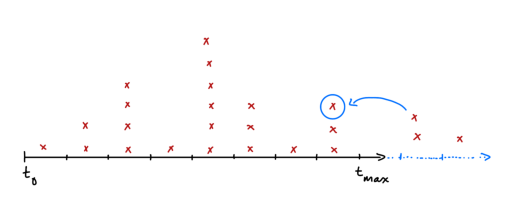

In [ ]:
# @title
# right hand adding events
img = mpimg.imread('/content/rh_add_event.png')
plt.imshow(img)
plt.axis('off')
plt.show()

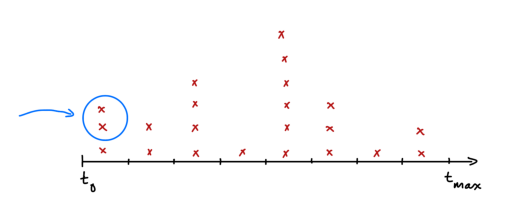

In [ ]:
# @title
# left hand delete events
img = mpimg.imread('/content/lh_add_event.png')
plt.imshow(img)
plt.axis('off')
plt.show()

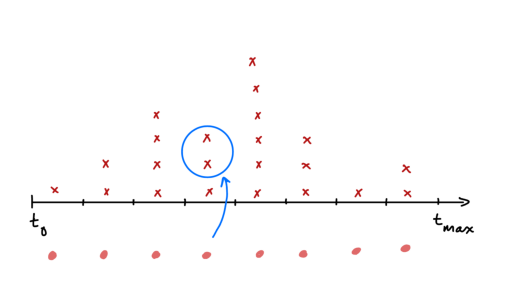

In [ ]:
# @title
#  adding events
img = mpimg.imread('/content/add_event.png')
plt.imshow(img)
plt.axis('off')
plt.show()

So what do each of these diagrams mean with respect to the types of moves? Three of them tackle to boundary or end points of the observation window while the fourth options adds unobserved events (called occults).

### Boundary conditions

#### Right side
- deleting event times from our observed window by placing them in the future
- adding events that may be in the future to the observation way

#### Left side
- initial condition changes

#### Middle
- adding unobserved events that _may_ be there

### Create a model

We will reuse the same SIR model as earlier.

In [ ]:
!pip install -Uq gemlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.lines import Line2D
from gemlib.distributions import DiscreteTimeStateTransitionModel

%matplotlib inline

In [ ]:
# define a model
incidence_matrix = np.array([[-1,  0],
                             [ 1, -1],
                             [ 0,  1]], dtype=np.float32)

initial_conditions = np.array([[999, 1, 0]], dtype=np.float32)

def make_transition_rate_fn(beta, gamma):
    # close over the parameters
    def rate_fn(t, state):

        si_rate = beta * state[:, 1] / tf.reduce_sum(state, axis=-1)
        ir_rate = tf.broadcast_to(gamma, si_rate.shape)

        return si_rate, ir_rate

    return rate_fn

In [ ]:
model = DiscreteTimeStateTransitionModel(
        transition_rate_fn=make_transition_rate_fn(beta=0.2, gamma=0.14),
        incidence_matrix=incidence_matrix,
        initial_state=initial_conditions,
        num_steps=84,
        name='sir_DA',
    )

In [ ]:
# simulate an epidemic
y = model.sample(seed = [0,7])

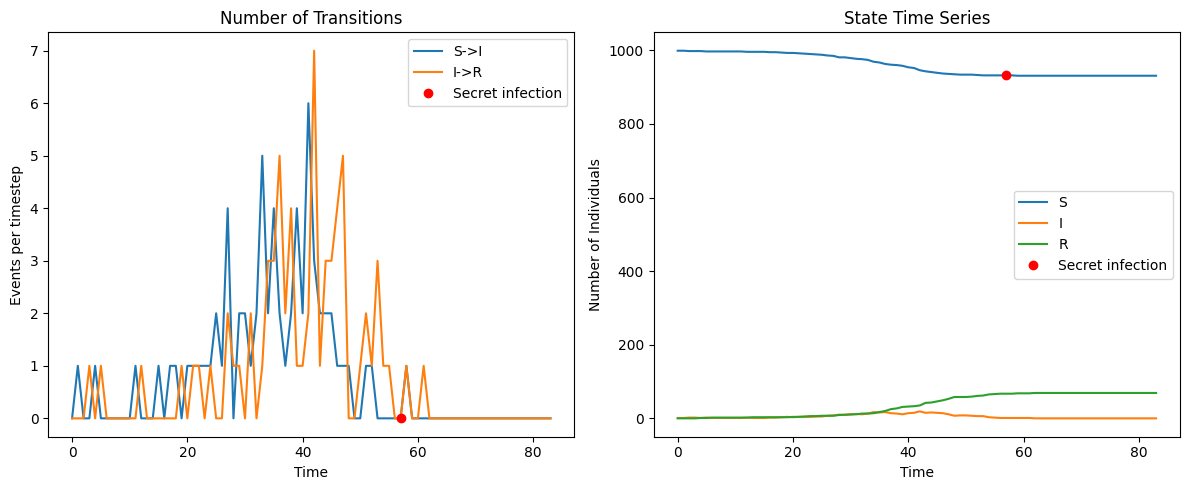

In [ ]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot the number of transitions
ax1.plot(y[:, 0, 0], label='S->I')
ax1.plot(y[:, 0, 1], label='I->R')
ax1.plot(57, y[57,0,0],'o', label="Secret infection", color = 'r')
ax1.legend()
ax1.set_xlabel("Time")
ax1.set_ylabel("Events per timestep")
ax1.set_title("Number of Transitions")

# Second subplot: Plot the curves
state_timeseries = model.compute_state(events=y)
ax2.plot(state_timeseries[:, 0, 0], label="S")
ax2.plot(state_timeseries[:, 0, 1], label="I")
ax2.plot(state_timeseries[:, 0, 2], label="R")
ax2.plot(57,state_timeseries[57, 0, 0], 'o', label="Secret infection", color = 'r')
ax2.legend()
ax2.set_xlabel("Time")
ax2.set_ylabel("Number of Individuals")
ax2.set_title("State Time Series")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

This begs the question
> How does this impact the epidemic?

If we think back to the likelihood evaluation sessions, we rely on a $\delta t_s$ component. Adding or deleting an event in the dataset will have a domino effect on other events around it because it _will_ impact the transition rates (and by extension the transition probabilities) at a given time. Running a data augmentation MCMC algorithm could let us catch events that the data recording process may have missed. The intuition of this is that for a given parameter set $\theta$, adding (or deleting) an event results in a more probable trajectory of the epidemic.

## `gemlib` implementation

Implementing these samplers from scratch is a challenging data engineering exercise since each type of move would result in a reordering and reshaping of the events that make up an epidemic. We've seen the additional steps needed for the move event sampler to work and the equivalent add/delete samplers are similar (though slightly more involved in order to manage the shape of the data to ensure we can still compile our code in XLA mode).

`gemlib` has already implemented several algorithms to do this for us. The remainder of this session will be time to experiment with these samplers and create your very own bespoke, compound MCMC algorithms which estimate parameter values _and_ missing data.

In [ ]:
from collections import namedtuple

# import samplers we will use
from gemlib.mcmc.discrete_time_state_transition_model import move_events
from gemlib.mcmc.discrete_time_state_transition_model import right_censored_events_mh
from gemlib.mcmc.discrete_time_state_transition_model import left_censored_events_mh
from gemlib.mcmc.mcmc_sampler import mcmc
from gemlib.mcmc.mwg_step import MwgStep

In [ ]:
# @title
move_kernel = MwgStep(
    move_events(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        num_units=1,
        delta_max=5,
        count_max=10,
    ),
    target_names=["value"],
    kernel_kwargs_fn=lambda _: {"initial_conditions": initial_conditions}
)

right_censored_kernel = MwgStep(
    right_censored_events_mh(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        count_max=10,
        t_range=(84-14, 84),  # Just add/del for the last 2 weeks of the epidemic
    ),
    target_names=["value"],
    kernel_kwargs_fn=lambda _: {"initial_conditions": initial_conditions}
)

kernel = move_kernel >> right_censored_kernel

In [ ]:
Position = namedtuple("Position", ["value"])
initial_position = Position(y)

@tf.function(jit_compile=True)
def run_mcmc(N):
    return mcmc(
        num_samples=N,
        sampling_algorithm=kernel,
        target_density_fn=model.log_prob,
        initial_position=initial_position,
        seed=[0,0],
        )


In [ ]:
samples, info = run_mcmc(1000)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times updates are not supported.  Using first event item only.
  pkr = self.inner_kernel.bootstrap_results(init_state)


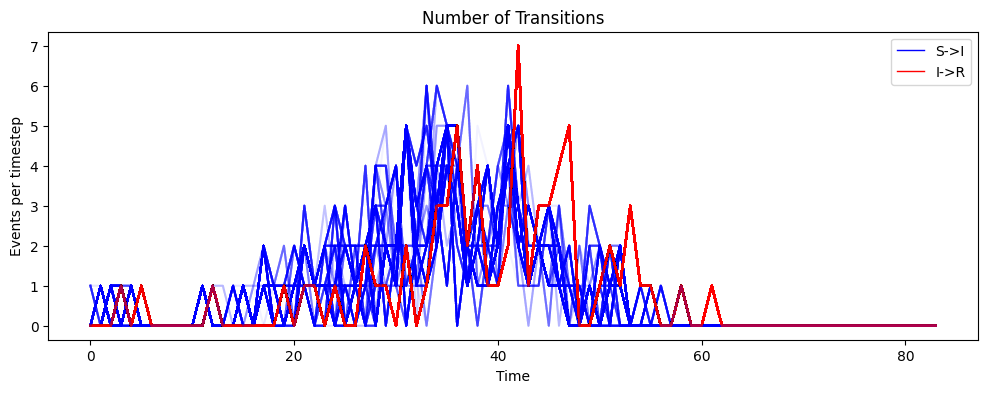

In [ ]:
# @title
fig = plt.figure(figsize = [12,4])

for i in range(500):
    plt.plot(samples[0][i][:,:,0],
             color='b',
             alpha = 0.051,
             label='S->I')
    plt.plot(samples[0][0][:,:,1],      # plot fixed events I -> R
             color='r',
             alpha = 0.1,
             label='I->R')

legend_elements = [Line2D([0], [0], color='b', lw=1, label='S->I'),
                   Line2D([0], [0], color='r', lw=1, label='I->R'),
                   ]

plt.legend(handles=legend_elements,)
plt.xlabel("Time")
plt.ylabel("Events per timestep")
plt.title("Number of Transitions")

plt.show()